# Gadget file

gadget_file.**open**(*filename*, *rescale_velocity*=True)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Returns a `GadgetFile` object.
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
`rescale_velocity`: rescales the square root factor the velocity in Gadget format.

f.**header**<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    The file header as a dictionary<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    np (tuple): number of particles in this file for 5
    particletypes<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    np_total (tuple): number of total particle in all files .0, .1, ...
    <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    m (tuple): mass of particle [internal unit]
    <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    a (float): scale factor
    <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    redshift (float)
    <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    nfiles (int): number of files for this snapshot
    <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    boxsize (float): length of the cubic simulation box on a side [internal unit]
    <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    omega_m (float): Omega matter at present
    <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    omega_lambda (float): Omega Lambda at present
    <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    h (float): Hubble constant in 100 km/s/Mpc

f[**component**]<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    f['x'][:] (array): positions [internal unit]
    <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    f['v'][:] (array): velocities [internal unit, $\sqrt{a}$ factor corrected.]
    <br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    f['xv'][:] (array): positions and velocities

* Assumes there is no gas (type 0) particles
* Reads only type 1 particles


In [ ]:
import lssps

with lssps.gadget_file.open('../data/snp_008.0') as f:
    header = f.header
    x = f['x']
    v = f['v']

print('header', header)
print('x', x)
print('v', v)

## Example
Compute the redshift-space power spectrum from a Gadget simulation data.

The redshift-space distortion is,
$$
s_3 = x_3 + \frac{v_3}{a H(a)}
$$
where, $a$ is the scale factor and
$$
H(a) = 100 \sqrt{\Omega_{m, 0} a^{-3} + \Omega_\Lambda} \quad [\mathrm{km} \,\mathrm{s}^{-1} (h^{-1} \mathrm{Mpc})^{-1}].
$$

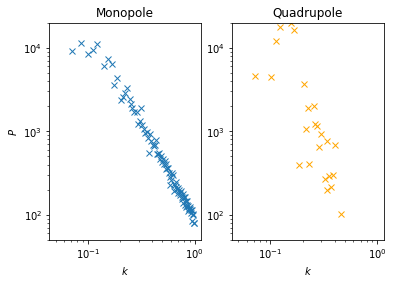

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import lssps

nc = 64 # number of grid points per dim for density grid and FFT
grid = None

# The snapshot is split into 2 files.
# Read particle and assign the number density to a grid
for filename in ['../data/snp_008.0', '../data/snp_008.0']:
    with lssps.gadget_file.open(filename) as f:
        xv = f['xv']
        a = f.header['a']
        omega_m = f.header['omega_m']
        boxsize = f.header['boxsize']
    
    # Redshift-space distortion
    H = 100*lssps.cosmology.H_factor(omega_m, a=a)
    fac = 1/(a*H)
    xv[:, 2] += fac*xv[:, 5]
    
    if grid is None:
        grid = lssps.grid.zeros(nc, boxsize)
    
    grid.assign_density(xv[:, 0:3])

grid.compute_fluctuation()

ps = lssps.power_spectrum.compute_plane_parallel(grid, line_of_sight=2)

# Plot power spectrum monopole and quadrupole
plt.figure()
plt.subplot(1, 2, 1)
plt.title('Monopole')
plt.xlabel('$k$')
plt.ylabel('$P$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(50, 2.0e4)
plt.plot(ps.k, ps.P0, 'x')

plt.subplot(1, 2, 2)
plt.title('Quadrupole')
plt.xlabel('$k$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(50, 2.0e4)
plt.plot(ps.k, ps.P2, 'x', color='orange')
plt.show()
